In [16]:
import os
import pickle
import numpy as np
import pandas as pd
import pydicom
import re
import seaborn as sns
import warnings
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from plotly.offline import init_notebook_mode
import scipy.ndimage
from skimage.morphology import disk, closing
from tqdm import tqdm
from PIL import Image
from os import listdir
import time

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

init_notebook_mode(connected=True)
%matplotlib inline

# Set Color Palettes for the notebook (https://color.adobe.com/)
colors_nude = ['#FFE61A','#B2125F','#FF007B','#14B4CC','#099CB3']

# Set Style
sns.set_style("whitegrid")

In [17]:
#### Defining constants and loading data
INCLUDE_CT_DATA = True
USE_PICKLED_DATA = True
IMAGE_PATH = "../input/osic-pulmonary-fibrosis-progression/"
test_pickle_path = "../Pickle/testing_df_unique_patients_ct.pkl"
train_pickle_path = "../Pickle/training_df_unique_patients_ct_2.pkl"

df_train = pd.read_csv(IMAGE_PATH + 'train.csv')
df_test = pd.read_csv(IMAGE_PATH + 'test.csv')
df_train["dcm_path"] = IMAGE_PATH + "train/" + df_train.Patient + "/"
df_test["dcm_path"] = IMAGE_PATH + "train/" + df_test.Patient + "/"

In [18]:
def load_scans(dcm_path):
    try:
        # in this competition we have missing values in ImagePosition, this is why we are sorting by filename number
        files = listdir(dcm_path)
        file_nums = [np.int(file.split(".")[0]) for file in files]
        sorted_file_nums = np.sort(file_nums)[::-1]
        slices = [pydicom.dcmread(dcm_path + "/" + str(file_num) + ".dcm" ) for file_num in sorted_file_nums]
        return slices
    except:
        print('Could not load scans')

def transform_to_hu(slices):
    try:
        images = np.stack([file.pixel_array for file in slices])
        images = images.astype(np.int16)

        # convert ouside pixel-values to air:
        # I'm using <= -1000 to be sure that other defaults are captured as well
        images[images <= -1000] = 0

        # convert to HU
        for n in range(len(slices)):

            intercept = slices[n].RescaleIntercept
            slope = slices[n].RescaleSlope

            if slope != 1:
                images[n] = slope * images[n].astype(np.float64)
                images[n] = images[n].astype(np.int16)

            images[n] += np.int16(intercept)

        return np.array(images, dtype=np.int16)
    except:
        print('error in converting to HU')

def get_window_value(feature):
    if type(feature) == pydicom.multival.MultiValue:
        return np.int(feature[0])
    else:
        return np.int(feature)

def resample(image, scan, new_spacing=None ):
    # Determine current pixel spacing
    if new_spacing is None:
	    new_spacing = [1,1,1]
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def fill_lungs(binary_image):
    image = binary_image.copy()
    # For every slice we determine the largest solid structure
    for i, axial_slice in enumerate(image):
        axial_slice = axial_slice - 1
        labeling = measure.label(axial_slice)
        l_max = largest_label_volume(labeling, bg=0)

        if l_max is not None: #This slice contains some lung
            image[i][labeling != l_max] = 1
    return image

def segment_lung_mask(image):
    try:
        start = time.time()
        segmented = np.zeros(image.shape)

        for n in range(image.shape[0]):
            binary_image = np.array(image[n] > -320, dtype=np.int8)+1
            labels = measure.label(binary_image)

            background_label_1 = labels[0,0]
            background_label_2 = labels[0,-1]
            background_label_3 = labels[-1,0]
            background_label_4 = labels[-1,-1]

            #Fill the air around the person
            binary_image[background_label_1 == labels] = 2
            binary_image[background_label_2 == labels] = 2
            binary_image[background_label_3 == labels] = 2
            binary_image[background_label_4 == labels] = 2

            #We have a lot of remaining small signals outside of the lungs that need to be removed.
            #In our competition closing is superior to fill_lungs
            selem = disk(4)
            binary_image = closing(binary_image, selem)

            binary_image -= 1 #Make the image actual binary
            binary_image = 1-binary_image # Invert it, lungs are now 1

            segmented[n] = binary_image.copy() * image[n]

        end = time.time()
        print('time to segment lung mask:', end - start, 'sec')
        return segmented
    except:
        print('lung mask error')

def resize_scan(scan, new_shape):
    # read slice as 32 bit signed integers
    img = Image.fromarray(scan, mode="I")
    # do the resizing
    img = img.resize(new_shape, resample=Image.LANCZOS)
    # convert back to 16 bit integers
    resized_scan = np.array(img, dtype=np.int16)
    return resized_scan

def crop_scan(scan):
    img = Image.fromarray(scan, mode="I")

    left = (scan.shape[0]-512)/2
    right = (scan.shape[0]+512)/2
    top = (scan.shape[1]-512)/2
    bottom = (scan.shape[1]+512)/2

    img = img.crop((left, top, right, bottom))
    # convert back to 16 bit integers
    cropped_scan = np.array(img, dtype=np.int16)
    return cropped_scan

def crop_and_resize(scan, new_shape):
    img = Image.fromarray(scan, mode="I")

    left = (scan.shape[0]-512)/2
    right = (scan.shape[0]+512)/2
    top = (scan.shape[1]-512)/2
    bottom = (scan.shape[1]+512)/2

    img = img.crop((left, top, right, bottom))
    img = img.resize(new_shape, resample=Image.LANCZOS)

    cropped_resized_scan = np.array(img, dtype=np.int16)
    return cropped_resized_scan

def preprocess_to_hu_scans(scan_properties, my_shape, output_dir):

    for i, patient in enumerate(tqdm(scan_properties.patient.values)):
        pth = scan_properties.loc[scan_properties.patient==patient].patient_pth.values[0]
        scans = load_scans(pth)
        hu_scans = transform_to_hu(scans)
        prepared_scans = np.zeros((hu_scans.shape[0], my_shape[0], my_shape[1]), dtype=np.int16)

        # if squared:
        if hu_scans.shape[1] == hu_scans.shape[2]:

            # if size is as desired
            if hu_scans.shape[1] == my_shape[0]:
                continue
            # else resize:
            else:
               # as we have not converted to jpeg to keep all information, we need to do a workaround
                hu_scans = hu_scans.astype(np.int32)
                for s in range(hu_scans.shape[0]):
                    prepared_scans[s] = resize_scan(hu_scans[s,:,:], my_shape)

        # if non-squared - do a center crop to 512, 512 and then resize to desired shape
        else:
            hu_scans = hu_scans.astype(np.int32)
            for s in range(hu_scans.shape[0]):
                # if desired shape is 512x512:
                if my_shape[0]==512:
                    prepared_scans[s] = crop_scan(hu_scans[s,:,:])
                else:
                    prepared_scans[s] = crop_and_resize(hu_scans[s,:,:], my_shape)

        # save the prepared scans of patient:
        np.save(output_dir + "/" + patient + '_hu_scans', prepared_scans)

def get_lung_pixels_and_slices(patient_path):
    scans = load_scans(patient_path)
    hu_scans = transform_to_hu(scans)
    segmented_lungs = segment_lung_mask(hu_scans)
    try:
        return np.count_nonzero(segmented_lungs), segmented_lungs.shape[0]
    except:
        print('error for patient', patient_path)

def create_scan_properties_df(df_raw, n):
    if n is None:
        n = df_raw.Patient.unique().shape[0]

    pixelspacing_r = []
    pixelspacing_c = []
    slice_thicknesses = []
    patient_id = []
    patient_pth = []
    row_values = []
    column_values = []
    window_widths = []
    window_levels = []

    patients = df_raw.Patient.unique()[0:n]

    for patient in patients:
        patient_id.append(patient)
        path = df_raw[df_raw.Patient == patient].dcm_path.values[0]

        example_dcm = listdir(path)[0]
        patient_pth.append(path)
        dataset = pydicom.dcmread(path + "/" + example_dcm)

        window_widths.append(get_window_value(dataset.WindowWidth))
        window_levels.append(get_window_value(dataset.WindowCenter))

        spacing = dataset.PixelSpacing
        slice_thicknesses.append(dataset.SliceThickness)

        row_values.append(dataset.Rows)
        column_values.append(dataset.Columns)
        pixelspacing_r.append(spacing[0])
        pixelspacing_c.append(spacing[1])

    scan_properties = pd.DataFrame(data=patient_id, columns=["patient"])
    scan_properties.loc[:, "rows"] = row_values
    scan_properties.loc[:, "columns"] = column_values
    scan_properties.loc[:, "area"] = scan_properties["rows"] * scan_properties["columns"]
    scan_properties.loc[:, "pixelspacing_r"] = pixelspacing_r
    scan_properties.loc[:, "pixelspacing_c"] = pixelspacing_c
    scan_properties.loc[:, "pixelspacing_area"] = scan_properties.pixelspacing_r * scan_properties.pixelspacing_c
    scan_properties.loc[:, "slice_thickness"] = slice_thicknesses
    scan_properties.loc[:, "patient_pth"] = patient_pth
    scan_properties.loc[:, "window_width"] = window_widths
    scan_properties.loc[:, "window_level"] = window_levels

    scan_properties["r_distance"] = scan_properties.pixelspacing_r * scan_properties.rows
    scan_properties["c_distance"] = scan_properties.pixelspacing_c * scan_properties["columns"]
    scan_properties["area_cm2"] = 0.1* scan_properties["r_distance"] * 0.1*scan_properties["c_distance"]
    scan_properties["slice_volume_cm3"] = 0.1*scan_properties.slice_thickness * scan_properties.area_cm2

    scan_properties["lung_pixels_and_slices"] = scan_properties.apply(lambda x: get_lung_pixels_and_slices(x.patient_pth), axis=1)
    return scan_properties

def read_dicom(patient_id, picture_id):
    # read a dcm file for a particular patient
    dcm_file_path = IMAGE_PATH + 'train/' + str(patient_id) + '/' + str(picture_id) + '.dcm'
    dcm = None
    try:
        dcm = pydicom.read_file(dcm_file_path)
    except:
        print('Could not read dicom file {} of patient {}'.format(picture_id, patient_id))
    return dcm

def get_all_patient_datasets(patient_id, patient_dir='train'):
    directory = IMAGE_PATH + patient_dir + "/" + patient_id
    datasets = []

    # First Order the files in the dataset
    files = []
    for dcm in list(os.listdir(directory)):
        files.append(dcm)
    if len(files) == 0:
        print('No datasets found for patient {} in directory {}'.format(patient_id, patient_dir))
        return None
    files.sort(key=lambda f: int(re.sub('\D', '', f)))
    # Read in the Dataset
    for dcm in files:
        path = directory + "/" + dcm
        try:
            datasets.append(pydicom.dcmread(path))
        except:
            print('Could not read dicom file for patient {} in directory {}'.format(patient_id, patient_dir))
            continue

    return datasets

def get_patient_id(dcm):
    if (0x0010, 0x0020) not in dcm:
        return None
    return dcm[0x0010, 0x0020].value

def get_slice_location(dcm):
    if (0x0020, 0x1041) not in dcm:
        print('Key for "Slice Location" does not exist')
        return None
    return float(dcm[0x0020, 0x1041].value)

def get_slice_thickness(dcm):
    if (0x0018, 0x0050) not in dcm:
        print('Key for "Slice Thickness" does not exist')
        return None
    return np.abs(float(dcm[0x0018, 0x0050].value))

def get_pixel_spacings(dcm):
    """
    :param dcm:
    :return: list of two values: [row_spacing, column_spacing]
    """
    if (0x0028, 0x0030) not in dcm:
        return None
    return dcm[0x0028, 0x0030].value

def get_slice_distance(patient_id: str, patient_dir='train'):
    datasets = get_all_patient_datasets(patient_id, patient_dir)
    if len(datasets) < 2:
        print('Less than 2 datasets available for patient {} in directory {}'.format(patient_id, patient_dir))
        return None

    i = 0
    while i < len(datasets):
        if not get_slice_location(datasets[i]) or not get_slice_location(datasets[i+1]):
            i += 1
            continue
        distance = np.abs(get_slice_location(datasets[i]) - get_slice_location(datasets[i+1]))
        if distance > 20:
            i += 1
            continue
        if distance > 0:
            return distance
        i += 1
        continue

    # if get_slice_location does not return anything useful, continue with get_slice_thickness
    i = 0
    while i < len(datasets):
        if not get_slice_thickness(datasets[i]) or get_slice_thickness(datasets[i]) > 20:
            i += 1
            continue
        distance = get_slice_thickness(datasets[i])
        if distance > 0:
            return distance
        i += 1
        continue

    print('Could not get valid slice distance')
    return None

def get_square_mm_per_pixel(patient_id: str, patient_dir='train'):
    datasets = get_all_patient_datasets(patient_id, patient_dir)
    if not datasets or len(datasets) == 0:
        return None
    if not get_pixel_spacings(datasets[0]):
        return None
    spacings = get_pixel_spacings(datasets[0])
    return spacings[0] * spacings[1]

def get_tissue_pixels(applied_mask, img_cropped):
    try:
        black_filter = (applied_mask > 0.2) & (applied_mask < 0.7)
        non_black = img_cropped[black_filter]
    except:
        print('Could not filter tissue')
        return 0
    return len(non_black)

def make_lungmask(img, display=False):
    try:
        # https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/
        img = crop_borders(img)
        row_size= img.shape[0]
        col_size = img.shape[1]
        mean = np.mean(img)
        std = np.std(img)
        img = img-mean
        img = img/std

        # Find the average pixel value near the lungs to renormalize washed out images
        middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)]
        mean = np.mean(middle)
        max = np.max(img)
        min = np.min(img)

        # To improve threshold finding, I'm moving the underflow and overflow on the pixel spectrum
        img[img==max]=mean
        img[img==min]=mean

        # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
        kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

        # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.
        # We don't want to accidentally clip the lung.

        eroded = morphology.erosion(thresh_img,np.ones([3,3]))
        dilation = morphology.dilation(eroded,np.ones([8,8]))

        labels = measure.label(dilation) # Different labels are displayed in different colors
        regions = measure.regionprops(labels)

        good_labels = []
        for prop in regions:
            B = prop.bbox
            height_check = row_size * 0.1 < B[2]-B[0] < row_size * 0.8
            width_check = col_size * 0.1 < B[3]-B[1] < col_size * 0.8
            position_row_check = B[0] > row_size * 0.2
            position_column_check = B[2] < col_size * 0.8
            if height_check and width_check and position_row_check and position_column_check:
                good_labels.append(prop.label)
            if len(good_labels) > 4:
                print('Lung mask contains more than 4 areas.')
                return False

        if len(good_labels) < 2:
            print('Lung mask contains less than 2 areas.')
            return False
        mask = np.ndarray([row_size,col_size],dtype=np.int8)
        mask[:] = 0

        #  After just the lungs are left, we do another large dilation
        #  in order to fill in and out the lung mask

        for N in good_labels:
            mask = mask + np.where(labels==N,1,0)
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
        if np.all(mask == 0):
            print('Black Image')
            return False
        applied_mask = mask*img
        tissue_only = np.where((applied_mask > 0.2) & (applied_mask < 0.7), 1, 0)

        if (display):
            fig, ax = plt.subplots(4, 2, figsize=[12, 12])
            ax[0, 0].set_title("Original")
            ax[0, 0].imshow(img, cmap='gray')
            ax[0, 0].axis('off')
            ax[0, 1].set_title("Threshold")
            ax[0, 1].imshow(thresh_img, cmap='gray')
            ax[0, 1].axis('off')
            ax[1, 0].set_title("After Erosion and Dilation")
            ax[1, 0].axis('off')
            ax[1, 0].imshow(dilation, cmap='gray')
            ax[1, 1].set_title("Color Labels")
            ax[1, 1].imshow(labels)
            ax[1, 1].axis('off')
            ax[2, 0].set_title("Final Mask")
            ax[2, 0].imshow(mask, cmap='gray')
            ax[2, 0].axis('off')
            ax[2, 1].set_title("Apply Mask on Original")
            ax[2, 1].imshow(mask*img, cmap='gray')
            ax[2, 1].axis('off')
            ax[3, 0].set_title("Tissue only")
            ax[3, 0].imshow(tissue_only, cmap='inferno')
            ax[3, 0].axis('off')
            plt.show()
        return img, applied_mask, mask
    except:
        return img, img, img

def analyse_patient_slices(patient_id, patient_dir='train'):
    # Set fallback lung data
    lung_data_default = (patient_id, 0, 0, 0, 0, 0, 0)
    try:
        datasets = get_all_patient_datasets(patient_id, patient_dir)
        if not datasets or len(datasets) == 0:
            return lung_data_default
        total_lung_pixels = 0
        total_tissue_within_lung_pixels = 0
        number_slices = len(datasets)
        for i in range(1, len(datasets) +1):
            print('.', end='')
            img, applied_mask, mask = None, None, None
            try:
                img, applied_mask, mask = make_lungmask(datasets[i-1].pixel_array)
            except:
                if number_slices > 0:
                    number_slices -= 1
                print('Mask creation skipped: Set {} patient {}'.format(i, patient_id))
                continue
            if mask is None:
                print('Lung mask of CT number {} of patient {} was None'.format(i, patient_id))
                if number_slices > 0:
                    number_slices -= 1
                continue
            lung_pixels = np.count_nonzero(mask == 1)
            tissue_within_lung_pixels = get_tissue_pixels(applied_mask, img)

            width, height = mask.shape
            total_pixels = width * height
            total_lung_pixels += lung_pixels
            total_tissue_within_lung_pixels += tissue_within_lung_pixels

            lung_percentage = np.round(lung_pixels / total_pixels * 100, 0)
            # print('Slice {}: {} Lung, {} Total, {} % Lung'.format(i, lung_pixels, total_pixels, lung_percentage))
        if number_slices == 0:
            return lung_data_default
        avg_slice_lung_pixels = total_lung_pixels/number_slices
        avg_tissue_within_lung_pixels = total_tissue_within_lung_pixels/number_slices
        slice_distance = get_slice_distance(patient_id, patient_dir=patient_dir)

        if not get_square_mm_per_pixel(patient_id, patient_dir=patient_dir) or not slice_distance:
            return lung_data_default

        mm2_per_pixel = get_square_mm_per_pixel(patient_id, patient_dir=patient_dir)
        avg_slice_lung_area_mm = avg_slice_lung_pixels * mm2_per_pixel
        avg_slice_fibrotic_tissue_area_mm = avg_tissue_within_lung_pixels * mm2_per_pixel
        lung_volume_mm3 = np.ceil(number_slices * slice_distance * avg_slice_lung_area_mm)
        lung_volume_cm3 = np.ceil(lung_volume_mm3 / 1000)
        lung_volume_liter = np.round(lung_volume_cm3 / 1000, 2)
        # print('Patient ID: ' + patient_id)
        # print('Number of Slices: ', number_slices)
        # print('Total Lung Pixels: ', total_lung_pixels)
        # print('Percentage fibrotic tissue', tissue_within_lung_pixels / lung_pixels)
        # print('Average lung pixels: ', avg_slice_lung_pixels)
        # print('Average lung area in mm²: ', avg_slice_lung_area_mm)
        # print('Slice distance: ', slice_distance)
        # print('Lung volume in cm³: ', lung_volume_cm3)
        # print('Lung volume in liter: ', lung_volume_liter)
        # print('###')
        return \
            patient_id, \
            lung_volume_cm3, \
            number_slices, \
            slice_distance, \
            avg_slice_lung_area_mm, \
            avg_slice_fibrotic_tissue_area_mm, \
            mm2_per_pixel
    except:
        return lung_data_default

def crop_borders(img):
    try:
        img = img[~np.all(img == img[0,:], axis=1)]
        img = img[:,~np.all(img == img[0,:], axis=0)]
    except:
        print('Could not crop borders')
    return img

def plot_all_patient_images(patient_id, only_mask=True, patient_dir='train'):
    datasets = get_all_patient_datasets(patient_id, patient_dir)
    columns = 10
    rows = int(np.ceil(len(datasets) / 10))
    fig=plt.figure(figsize=(16, rows * 2))

    for i in range(1, len(datasets) +1):
        img, applied_mask, mask = None
        try:
            img, applied_mask, mask = make_lungmask(datasets[i-1].pixel_array)[1]
        except AttributeError:
            print('Could not make lung mask of picture', i)
        if only_mask:
            displayed_img = mask
        else:
            displayed_img = applied_mask

        if displayed_img is not None :
            fig.add_subplot(rows, columns, i)
            plt.imshow(displayed_img)
            plt.title(i, fontsize = 9)
            plt.axis('off')

def show_all_masks(patient_id, picture_id):
    # Show all masks of one picture
    dataset = read_dicom(patient_id, picture_id)

    img = dataset.pixel_array
    # Masked image
    make_lungmask(img, display=True)
    # except:
    #     print('Could not convert image to pixels')

def cat_to_binary(value, cat_name):
    if value == cat_name:
        return 1
    else:
        return 0

def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values = False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    try:
        sd_clipped = np.maximum(confidence, 70)
        delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
        metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

        if return_values:
            return metric
        else:
            return np.mean(metric)
    except:
        print('Could not calculate LLL')
        return 0

def calculate_gradient_coef_for_patient(patient_records_df):
    X_train = patient_records_df[['Weeks']]
    y_train = patient_records_df[['FVC']]
    try:
        model = LinearRegression(normalize=True).fit(X_train, y_train)
        return model.coef_[0][0]
    except:
        print('Could not fit LinearRegression model')
        return 0

def prepare_patient_data(df_raw, patient_id, df_new):
    try:
        # Filter by single patients
        patient_records_df = df_raw[df_raw.Patient == patient_id]
        number_records = len(patient_records_df)
        gradient_coef = calculate_gradient_coef_for_patient(patient_records_df)
        max_fvc = patient_records_df[['FVC']].max()[0]
        min_fvc = patient_records_df[['FVC']].min()[0]
        std_fvc = patient_records_df[['FVC']].std()[0]
        if np.isnan(std_fvc):
            std_fvc = 0

        first_measurement = patient_records_df.iloc[0]
        last_measurement = patient_records_df.iloc[number_records - 1]
        diff_abs_fvc = last_measurement['FVC'] - first_measurement['FVC']
        # print('L {} - F {} = {}'.format(last_measurement['FVC'], first_measurement['FVC'], diff_abs_fvc))
        df_unique_patient = pd.DataFrame(
            index=[patient_id],
            columns=[
                'FVC_First',
                'FVC_Last',
                'Diff_FVC_Abs',
                'Gradient_Coef',
                'Max_FVC',
                'Min_FVC',
                'Std_FVC'
            ],
            data=[[
                first_measurement['FVC'],
                last_measurement['FVC'],
                diff_abs_fvc,
                gradient_coef,
                max_fvc,
                min_fvc,
                std_fvc]]
        )
        df_unique_patient['First_Week'] = first_measurement['Weeks']
        df_unique_patient['Percent'] = first_measurement['Percent']
        df_unique_patient['Age'] = first_measurement['Age']
        df_unique_patient['Sex'] = first_measurement['Sex']
        df_unique_patient['SmokingStatus'] = first_measurement['SmokingStatus']
        df_unique_patient['Male'] = cat_to_binary(first_measurement['Sex'], 'Male')
        df_unique_patient['Female'] = cat_to_binary(first_measurement['Sex'], 'Female')
        df_unique_patient['NeverSmoked'] = cat_to_binary(first_measurement['SmokingStatus'], 'Never smoked')
        df_unique_patient['ExSmoker'] = cat_to_binary(first_measurement['SmokingStatus'], 'Ex-smoker')
        df_unique_patient['CurrentlySmokes'] = cat_to_binary(first_measurement['SmokingStatus'], 'Currently smokes')

        df_new = df_new.append(df_unique_patient)
        return df_new
    except:
        print('Could not prepare patient data for patient {}'.format(patient_id))
        return df_new

def prepare_unique_patients_train_df(df_train):
    try:
        df_unique_patients = pd.DataFrame(
            columns=[
                'First_Week',
                'FVC_First',
                'FVC_Last',
                'Diff_FVC_Abs',
                'Gradient_Coef',
                'Max_FVC',
                'Min_FVC',
                'Std_FVC',
                'Percent',
                'Age',
                'Sex',
                'SmokingStatus',
                'Male',
                'Female',
                'NeverSmoked',
                'ExSmoker',
                'CurrentlySmokes'
            ])
        unique_patient_ids = df_train['Patient'].unique()
        for patient_id in unique_patient_ids:
            df_unique_patients = prepare_patient_data(df_train, patient_id, df_unique_patients)
        return df_unique_patients
    except:
        print('Could not prepare unique patients dataframe')
        return None

def prepare_unique_patients_test_df(df_test):
    try:
        df_test = df_test.set_index('Patient')
        df_test['Male'] = df_test.apply (lambda x: cat_to_binary(x['Sex'], 'Male'), axis=1)
        df_test['Female'] = df_test.apply (lambda x: cat_to_binary(x['Sex'], 'Female'), axis=1)
        df_test['NeverSmoked'] = df_test.apply (lambda x: cat_to_binary(x['SmokingStatus'], 'Never smoked'), axis=1)
        df_test['ExSmoker'] = df_test.apply (lambda x: cat_to_binary(x['SmokingStatus'], 'Ex-smoker'), axis=1)
        df_test['CurrentlySmokes'] = df_test.apply (lambda x: cat_to_binary(x['SmokingStatus'], 'Currently smokes'), axis=1)
        return df_test
    except:
        print('Could not prepare test unique patients dataframe')
        return None

def prepare_boosting_data_x(df_unique_patients, hasCtData=True):
    # Prepare unique patients an make them suitable for gradient boosting model
    try:
        if hasCtData:
            x = df_unique_patients[[
                'Percent',
                'Age',
                'Male',
                'Female',
                'NeverSmoked',
                'ExSmoker',
                'CurrentlySmokes',
                'lung_volume_cm3',
                'percentage_fibrotic_tissue'
            ]].to_numpy()
        else:
            x = df_unique_patients[[
                'Percent',
                'Age',
                'Male',
                'Female',
                'NeverSmoked',
                'ExSmoker',
                'CurrentlySmokes'
            ]].to_numpy()
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        return  x_scaled
    except:
        print('Could not prepare boosting data x')
        return None

def prepare_boosting_data_y(df_unique_patients):
    try:
        return df_unique_patients[['Gradient_Coef']].values.ravel()
    except:
        print('Could not prepare boosting data y')
        return None

def test_boost_performance(df_train, test_patients, mean_std_fvc, std_dev_multiplier = 5):
    """
    Create test submission values to check LLL on test split
    Takes in the coefficients of the test group of the boost model split and calculates LLL based on the
    full df_train with all measurements
    :param df_train: All train measurements of all patients. Is needed to get all measurements of the
                        test candidates
    :param test_patients: A patient dataframe (unique patients) from the test split
    :param y_test_predicted: Linear gradient coefficients for each test patient
    """
    test_patient_ids = list(test_patients.index.values)
    df_test_patient_measurements = df_train[df_train.Patient.isin(test_patient_ids)]
    lll_total = 0

    for index, row in df_test_patient_measurements.iterrows():
        week = row['Weeks']
        first_measurement = test_patients.loc[row.Patient]
        patient_sample_fvc = first_measurement['FVC_First']
        patient_sample_week = first_measurement['First_Week']
        coef_predicted = first_measurement['Gradient_Predicted']
        predicted_fvc = np.round(patient_sample_fvc + (week - patient_sample_week) * coef_predicted, 0)
        std_dev = np.round(mean_std_fvc * std_dev_multiplier * np.abs(week - patient_sample_week) / 145)
        lll = laplace_log_likelihood(row['FVC'], predicted_fvc, std_dev)
        # print('FVC real: {} FVC predicted: {} StdDev: {} LLL: {}'.format(row['FVC'], predicted_fvc, std_dev, lll))
        lll_total += lll
    return lll_total / len(df_test_patient_measurements)

def calculate_public_board_lll(df_test, df_train, df_submission):
    try:
        test_patient_ids = list(df_test['Patient'])
        last_n_results = 3
        lll_total = 0
        predicted_fvc = 0
        for patient_id in test_patient_ids:
            df_patient = df_train[df_train['Patient'] == patient_id].tail(last_n_results)
            for index, row in df_patient.iterrows():
                week = row['Weeks']
                predicted_fvc = float(df_submission.loc[df_submission['Patient_Week'] == patient_id + '_' + str(week)]['FVC'].values[0])
                confidence = float(df_submission.loc[df_submission['Patient_Week'] == patient_id + '_' + str(week)]['Confidence'].values[0])
                lll = laplace_log_likelihood(row['FVC'], predicted_fvc, confidence, return_values = True)
                lll_total += lll
        print('Public Board LLL', predicted_fvc, lll_total / (len(test_patient_ids) * last_n_results))
    except:
        print('Error on calculating public board LLL')

def create_debug_submission(df_raw, fvc, confidence):
    weeks = range(-12, 134, 1)
    arr = np.empty((0,3), int)

    for i in range(len(df_raw)):
        for week in weeks:
            patient_week = df_raw.at[i, 'Patient'] + '_' + str(week)
            arr = np.append(arr, np.array([[patient_week, fvc, confidence]]), axis=0)

    df_submission = pd.DataFrame(arr, columns=['Patient_Week', 'FVC', 'Confidence'])
    df_submission.to_csv('submission.csv', index=False)
    return df_submission

def create_linear_decay_submission(df_raw, coef_predicted, mean_std, std_dev_multiplier):
    weeks = range(-12, 134, 1)
    arr = np.empty((0,3), int)
    df_raw = df_raw.fillna(value=1)

    for i in range(len(df_raw)):
        if isinstance(coef_predicted, float):
            coef = coef_predicted
        else:
            coef = float(coef_predicted[i])
        # calculate_public_board_lll(df_test, df_train, create_debug_submission(df_test, i*50+50, i*50+50))
        for week in weeks:
            try:
                patient_week = df_raw.at[i, 'Patient'] + '_' + str(week)
            except:
                print('Except 1')
                patient_week = 0
            try:
                patient_sample_fvc = df_raw.at[i, 'FVC']
            except:
                print('Except 2')
                patient_sample_fvc = 0
            try:
                patient_sample_week = df_raw.at[i, 'Weeks']
            except:
                print('Except 3')
                patient_sample_week = 0
            try:
                predicted_fvc = int(np.round(patient_sample_fvc + (week - patient_sample_week) * coef,0))
                if predicted_fvc < 0:
                    predicted_fvc = 0
            except:
                print('Except 4')
                predicted_fvc = 0
            try:
                std_dev = int(np.round(mean_std * std_dev_multiplier * np.abs(week - patient_sample_week) / 145))
                if std_dev < 0:
                    std_dev = 0
            except:
                print('Except 5')
                std_dev = 0
            try:
                arr = np.append(arr, np.array([[patient_week, predicted_fvc, std_dev]]), axis=0)
            except:
                print('Except 6')

    # calculate_public_board_lll(df_test, df_train, create_debug_submission(df_test, 500, 500))
    df_submission = pd.DataFrame(arr, columns=['Patient_Week', 'FVC', 'Confidence'])

    try:
        # calculate_public_board_lll(df_test, df_train, create_debug_submission(df_test, 800, 800))
        df_submission.to_csv('submission.csv', index=False)
    except:
        print('could not create CSV file')

    return df_submission

def get_tuple_item(input_tuple, item_number):
    try:
        if input_tuple[0] and input_tuple[0][item_number]:
            return input_tuple[0][item_number]
        return 0
    except:
        print('Could not get tuple information', input_tuple, item_number)
        return 0

def iterate_patient_cts(df_unique_patients, prefix: str, patient_dir='train'):
    lung_datas = []
    i = 0

    for index, row in df_unique_patients.iterrows():
        i += 1
        lung_data = analyse_patient_slices(index, patient_dir)
        print('')
        print('CT Result:', i, index, lung_data)
        lung_datas.append(lung_data)
        pickle.dump( lung_data, open( prefix + "_lung_data.p", "wb" ) )
    df_unique_patients['lungDataCt'] = lung_datas
    df_unique_patients.to_pickle("../Pickle/{}_df_unique_patients_ct.pkl".format(prefix), protocol=2)

    return df_unique_patients

def add_ct_data_to_df(ct_df):
    try:
        ct_df['lung_volume_cm3'] = ct_df.apply(lambda x:get_tuple_item(x[['lungDataCt']], 1), axis=1)
        ct_df['number_slices'] = ct_df.apply(lambda x:get_tuple_item(x[['lungDataCt']], 2), axis=1)
        ct_df['slice_distance'] = ct_df.apply(lambda x:get_tuple_item(x[['lungDataCt']], 3), axis=1)
        ct_df['avg_slice_lung_area_mm'] = ct_df.apply(lambda x:get_tuple_item(x[['lungDataCt']], 4), axis=1)
        ct_df['avg_slice_fibrotic_tissue_area_mm'] = ct_df.apply(lambda x:get_tuple_item(x[['lungDataCt']], 5), axis=1)
        ct_df['get_square_mm_per_pixel'] = ct_df.apply(lambda x:get_tuple_item(x[['lungDataCt']], 6), axis=1)
        ct_df['percentage_fibrotic_tissue'] = ct_df['avg_slice_fibrotic_tissue_area_mm'] / ct_df['avg_slice_lung_area_mm']
        ct_df = ct_df.fillna(0)
    except:
        print('Error on adding CT data to dataframe')
    return ct_df

In [20]:
scan_properties_df = create_scan_properties_df(df_train, 1)
scan_properties_df.to_pickle("../Pickle/scan_properties_df.pkl", protocol=2)
scan_properties_df.head()

time to segment lung mask: 2.011878728866577 sec


,patient,rows,columns,area,pixelspacing_r,pixelspacing_c,pixelspacing_area,slice_thickness,patient_pth,window_width,window_level,r_distance,c_distance,area_cm2,slice_volume_cm3,lung_pixels_and_slices
0,ID00007637202177411956430,512,512,262144,0.652344,0.652344,0.425553,1.25,../input/osic-pulmonary-fibrosis-progression/t...,-1500,-500,334.000128,334.000128,1115.560855,139.445107,"(681354, 30)"


In [21]:
if USE_PICKLED_DATA:
    #### Load data from pickle
    df_unique_patients = pd.read_pickle(train_pickle_path)
else:
    #### Create initial dataframe for unique patients
    df_unique_patients = prepare_unique_patients_train_df(df_train)

if INCLUDE_CT_DATA:
    if not USE_PICKLED_DATA:
        #### get additional data from CTs
        df_unique_patients = iterate_patient_cts(df_unique_patients, 'training', 'train')
    df_unique_patients = add_ct_data_to_df(df_unique_patients)

df_unique_patients.head()

,First_Week,FVC_First,FVC_Last,Diff_FVC_Abs,Gradient_Coef,Max_FVC,Min_FVC,Std_FVC,Percent,Age,...,ExSmoker,CurrentlySmokes,lungDataCt,lung_volume_cm3,number_slices,slice_distance,avg_slice_lung_area_mm,avg_slice_fibrotic_tissue_area_mm,get_square_mm_per_pixel,percentage_fibrotic_tissue
ID00007637202177411956430,-4,2315,2057,-258,-3.167126,2315,2000,96.856136,58.253649,79,...,1,0,"(ID00007637202177411956430, 3553.0, 18, 10.0, ...",3553.0,18,10.000000,19734.320587,6024.856837,0.425553,0.305298
ID00009637202177434476278,8,3660,3214,-446,-9.379955,3895,3214,197.367677,85.282878,69,...,1,0,"(ID00009637202177434476278, 3222.0, 190, 0.799...",3222.0,190,0.799999,21193.048205,3114.268412,0.237149,0.146948
ID00010637202177584971671,0,3523,2518,-1005,-17.042803,3523,2474,358.433901,94.724672,60,...,1,0,"(ID00010637202177584971671, 2278.0, 60, 3.0, 1...",2278.0,60,3.000000,12655.379699,2373.161070,0.428104,0.187522
ID00011637202177653955184,6,3326,3193,-133,-4.548925,3541,3193,113.773899,85.987590,72,...,1,0,"(ID00011637202177653955184, 0, 0, 0, 0, 0, 0)",0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000
ID00012637202177665765362,33,3418,2971,-447,-8.543079,3759,2971,212.432211,93.726006,65,...,0,0,"(ID00012637202177665765362, 2741.0, 23, 7.0, 1...",2741.0,23,7.000000,17023.097826,3436.294158,0.390625,0.201861


In [22]:
#### Prepare train datasets for training
train_patients, test_patients = train_test_split(df_unique_patients, test_size=0.2, random_state=42)

#### Set up gradient boosting model and train
X_train = prepare_boosting_data_x(train_patients, hasCtData=INCLUDE_CT_DATA)
y_train = prepare_boosting_data_y(train_patients)
X_test = prepare_boosting_data_x(test_patients, hasCtData=INCLUDE_CT_DATA)
y_test = prepare_boosting_data_y(test_patients)

params = {'n_estimators': 50,
          'max_depth': 5,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

reg = ensemble.GradientBoostingRegressor(**params)

#### Train gradient boosting model
try:
    reg.fit(X_train, y_train)
except:
    print('Could not fit GradientBoostingRegressor')

y_test_predicted = None
try:
    y_test_predicted = reg.predict(X_test)
except:
    print('Could not predict y test')

mse = mean_squared_error(y_test, y_test_predicted)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 54.9193


In [23]:
if USE_PICKLED_DATA:
    #### Load data from pickle
    df_unique_patients_test = pd.read_pickle(test_pickle_path)
else:
    #### Create unique patients in test set for submission
    df_unique_patients_test = prepare_unique_patients_test_df(df_test)

if INCLUDE_CT_DATA:
    if not USE_PICKLED_DATA:
        #### get additional data from CTs
        df_unique_patients_test = iterate_patient_cts(df_unique_patients=df_unique_patients_test, prefix='testing', patient_dir='test')
    df_unique_patients_test = add_ct_data_to_df(df_unique_patients_test)

X_test_submit = prepare_boosting_data_x(df_unique_patients_test, hasCtData=INCLUDE_CT_DATA)
coef_predicted_submission = None

try:
    coef_predicted_submission = reg.predict(X_test_submit)
except:
    print('Coef for submission could not be predicted')
print(coef_predicted_submission)


[-2.20313813 -2.45297661 -2.81989143 -3.97994999 -2.86250975]


In [24]:
#### Create submission files
mean_std_fvc = df_unique_patients.Std_FVC.mean()
std_dev_multiplier = 14
# df_submission2 = create_linear_decay_submission(df_test, coef_predicted_submission2, mean_std_fvc, std_dev_multiplier)
# calculate_public_board_lll(df_test, df_train, df_submission2)
df_submission = create_linear_decay_submission(df_test, coef_predicted_submission, mean_std_fvc, std_dev_multiplier)
calculate_public_board_lll(df_test, df_train, df_submission)

Public Board LLL 2756.0 -7.2689169224816315


In [25]:
#### Test submission values on LLL for gradient boost
test_patients.insert(2, 'Gradient_Predicted', y_test_predicted)
for std_dev_multiplier in range(1,20):
    print('Multiplier:', std_dev_multiplier)
    lll_total = test_boost_performance(df_train, test_patients, mean_std_fvc, std_dev_multiplier)
    print('LLL for test split is {} for std dev multiplier of {}'.format(lll_total, std_dev_multiplier))
    df_submission = create_linear_decay_submission(df_test, coef_predicted_submission, mean_std_fvc, std_dev_multiplier)
    # calculate_public_board_lll(df_test, df_train, df_submission)
std_dev_multiplier = 14
lll_total = test_boost_performance(df_train, test_patients, mean_std_fvc, std_dev_multiplier)
print('LLL for test split is {} for std dev multiplier of {}'.format(lll_total, std_dev_multiplier))

Multiplier: 1
LLL for test split is -7.279325451508104 for std dev multiplier of 1
Multiplier: 2
LLL for test split is -7.098209409734226 for std dev multiplier of 2
Multiplier: 3
LLL for test split is -6.911213891990296 for std dev multiplier of 3
Multiplier: 4
LLL for test split is -6.810204191956041 for std dev multiplier of 4
Multiplier: 5
LLL for test split is -6.747901083026261 for std dev multiplier of 5
Multiplier: 6
LLL for test split is -6.7055033676487765 for std dev multiplier of 6
Multiplier: 7
LLL for test split is -6.6735323779314655 for std dev multiplier of 7
Multiplier: 8
LLL for test split is -6.649996089383018 for std dev multiplier of 8
Multiplier: 9
LLL for test split is -6.63015313977336 for std dev multiplier of 9
Multiplier: 10
LLL for test split is -6.6154958370696235 for std dev multiplier of 10
Multiplier: 11
LLL for test split is -6.60721842248799 for std dev multiplier of 11
Multiplier: 12
LLL for test split is -6.599275431184992 for std dev multiplier of 

[6386.]
[0.23236754]
[1400.]
[0.09771045]
[2838.]
[0.25868148]
[1360.]
[0.178111]
[5490.]
[0.09066701]


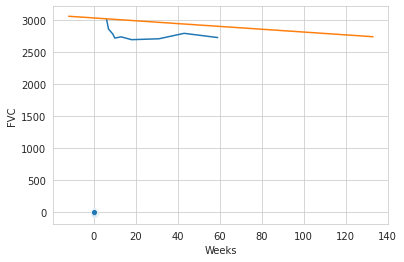

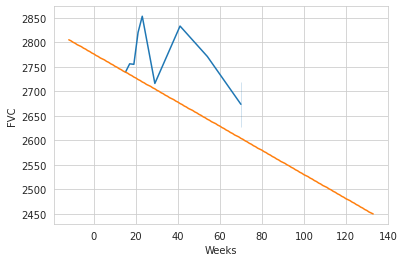

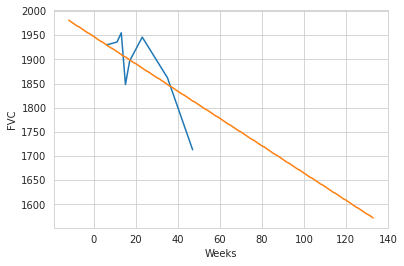

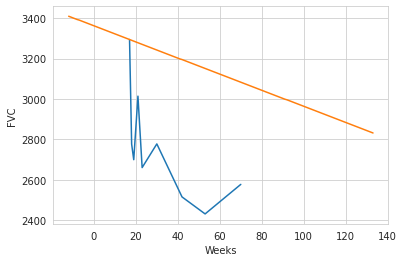

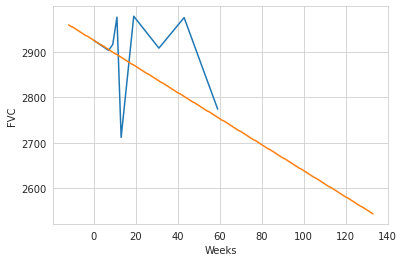

In [26]:
if INCLUDE_CT_DATA:
    sns.scatterplot(x='percentage_fibrotic_tissue', y='Gradient_Coef',data=df_unique_patients)

    p_id = list(df_test.Patient)

    for patient in p_id:
        print(df_unique_patients_test[df_unique_patients_test.index.str.startswith(patient)]['lung_volume_cm3'].values)
        print(df_unique_patients_test[df_unique_patients_test.index.str.startswith(patient)]['percentage_fibrotic_tissue'].values)
        x1 = range(-12, 134, 1)
        y1 = df_submission[df_submission.Patient_Week.str.startswith(patient)]['FVC'].values
        y1 = [int(i) for i in y1]
        sns.lineplot(x = "Weeks", y = "FVC", data = df_train[df_train.Patient == patient], markers = ["o", "<"])
        sns.lineplot(x = x1, y = y1, markers = ["o", "<"])
        plt.show()

In [29]:
scan_properties = pd.read_pickle('../Pickle/scan_properties_df.pkl')
scan_properties.head(1)

,patient,rows,columns,area,pixelspacing_r,pixelspacing_c,pixelspacing_area,slice_thickness,patient_pth,window_width,window_level,r_distance,c_distance,area_cm2,slice_volume_cm3,lung_pixels_and_slices
0,ID00007637202177411956430,512,512,262144,0.652344,0.652344,0.425553,1.25,../input/osic-pulmonary-fibrosis-progression/t...,-1500,-500,334.000128,334.000128,1115.560855,139.445107,"(681354, 30)"
